In [615]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

from utils import to_datetime, get_Data
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [616]:
def to_date(x): 
    return datetime.fromtimestamp(x).strftime('%Y-%m-%d') 

# Creating the portforlios

In [617]:
newGlob = get_Data()
monthly_returns = pd.read_csv("data/44.csv", index_col=0)
monthReturns = monthly_returns.T
data_size = pd.read_csv("./data/1.csv",index_col=0)
dates = data_size.index
stocks = data_size.columns

### Extracting the stocks used in our portfolio

In [618]:
#To obtain the stocks that are taken into account in our portfolio
 
# Takes in input an array and returns two diferrent arrays representing the two deciles
def recuperer_stocks(r) :
    decile_1 = np.percentile(r, 10)
    decile_9 = np.percentile(r, 90)
    stock_low = np.where(r<decile_1)[0]
    stock_high = np.where(r>decile_9)[0]
    return stock_high,stock_low

### Assigning weights to this stocks

In [619]:
def portefeuille(stock_high,stock_low,nbr_stocks = 254) :
    n1=np.shape(stock_high)[0]
    n2=np.shape(stock_low)[0]
    w=np.zeros(nbr_stocks)
    for i in stock_high :
        w[i]=(1)/n1
    for i in stock_low:
        w[i]=(-1)/n2
    return w

#### Formular calculating the Turnover

In [620]:
#take an array representing the (real) expected return of each stocks for each month 
#and an array representing the weights of the portfolio for T months
def TO(w,r):
    N,T=np.shape(w)
    turn=np.zeros((N,T))
    for i in range(N):
        for t in range(T-1):
            turn[i,t]=abs(w[i,t+1] - w[i,t]*(1+r[i,t+1])/(1+np.sum(w[:,t]*r[:,t+1])))
    turnover=(1/T) * np.sum(np.sum(turn,axis=0))
    return turnover

### Formular calculating the returns of a portfolio

In [621]:
#take an array representing the (real) expected return of each stocks for each month
def esperance_portefolio(r,w,month):
    return np.sum(r[:, month]*w[:, 0])

def esperance_switch_portfolio(r,w,month):
    return np.sum(r[:, month]*w[:, month])

### Function evaluating the loss due when changing your position on the assets 
''' def esperance_switch_portfolio(r, w, month, dates):
    global newGlob
    curent_month = np.sum(r[:, month]*w[:, month])
    switching_loss = 0
    if month > 0: 
        n, m = w.shape
        for k in range(n): 
            if w[k, month] != w[k, month -1]:
                p_t1 = newGlob[(newGlob["Date"] == to_datetime(dates[month - 1])) & (newGlob.index == stocks[k])]["price"].to_numpy()[0]
                p_t2 = newGlob[(newGlob["Date"] == to_datetime(dates[month])) & (newGlob.index == stocks[k])]["price"].to_numpy()[0]
                r_loss = (1/np.where(w[:, month-1] > 0)[0].shape[0])*((p_t2 - p_t1)/p_t1)
                switching_loss += r_loss
    final_return = curent_month + switching_loss
    return final_return '''

' def esperance_switch_portfolio(r, w, month, dates):\n    global newGlob\n    curent_month = np.sum(r[:, month]*w[:, month])\n    switching_loss = 0\n    if month > 0: \n        n, m = w.shape\n        for k in range(n): \n            if w[k, month] != w[k, month -1]:\n                p_t1 = newGlob[(newGlob["Date"] == to_datetime(dates[month - 1])) & (newGlob.index == stocks[k])]["price"].to_numpy()[0]\n                p_t2 = newGlob[(newGlob["Date"] == to_datetime(dates[month])) & (newGlob.index == stocks[k])]["price"].to_numpy()[0]\n                r_loss = (1/np.where(w[:, month-1] > 0)[0].shape[0])*((p_t2 - p_t1)/p_t1)\n                switching_loss += r_loss\n    final_return = curent_month + switching_loss\n    return final_return '

### Formular calculating the MaxDD

In [623]:
#take an array representing the (real) expected return of each stocks for each month
def maxDD(r,w):
    n,m=np.shape(r)
    x=np.zeros(m)
    for month in range(m):
        x[month]=esperance_portefolio(r,w,month)
    Y=np.cumsum(x)
    diff=np.zeros((m,m))
    for t1 in range(m):
        for t2 in range(m):
            diff[t1,t2] = Y[t1]-Y[t2]
    return np.max(diff)

### Formular calculating the Max 1M Loss

In [624]:
#take an array representing the (real) expected return of each stocks for each month
#return the most extrem negative return for all stocks in the portefolio and T months considered
def Max1Mloss(r):
    mini=[]
    for month in range(np.shape(r)[1]):
        l=[]
        for stock in recuperer_stocks(r[:,month])[0]:
            #print(stock) #for each months, we save the return of the chosen stocks
            l.append(r[stock,month])
        for stock in recuperer_stocks(r[:,month])[1]:
            l.append(r[stock,month])
        #print(l)
        mini.append(min(l)) #save the minimum return for one month
    return np.min(mini)

### Fucntion needed to compute the cumulative returns

In [625]:
def esperance_short_portfolio(r,w):
    nbr = w.shape[0]
    w_short=np.zeros(nbr)
    for i in range(nbr):
        w_short[i]=min(0,w[i])
    return sum(r*w_short)

def esperance_long_portfolio(r,w):
    nbr = w.shape[0]
    w_long=np.zeros(nbr)
    for i in range(nbr):
        w_long[i]=max(0,w[i])
    return sum(r*w_long)

def cumulative_return(r,w):
    n,m = r.shape
    x1=np.zeros(m)
    x2=np.zeros(m)
    for month in range(m):
        x1[month]=esperance_long_portfolio(r[:, month],w[:,0])
        x2[month]=esperance_short_portfolio(r[:, month],w[:, 0])
    Y_long=np.cumsum(x1)
    Y_short=np.cumsum(x2)
    return Y_long,Y_short

## Creation of the global functions analysing the portfolios

In [626]:
Months = []
Years = []
Predictions = []
Reals = []
compare_methods = dict()
compare_methods_switch = dict()
Cumulate = pd.DataFrame()

In [627]:
# Specific dates used to split the data
deb = to_datetime("1999-12-31")
trainDat = to_datetime("2012-12-31") #2021-12-31"
valDat = to_datetime("2014-12-31")#2021-12-31

In [628]:
# A necessity for the PCA model
X_train = newGlob[(newGlob["Date"] >= deb) & (newGlob["Date"] <= trainDat)]
X_train = X_train.drop(columns= ["Date", "Returns"])
X_train_norm = pd.DataFrame(StandardScaler().fit_transform(X_train))
PCA_model = PCA(n_components=0.95, svd_solver = 'full')
PCA_model.fit(X_train_norm)

PCA(n_components=0.95, svd_solver='full')

In [629]:
def predict_returns(model, name):

    global stocks, dates, newGlob, PCA_model

    Result = pd.DataFrame()
    
    yearXtrain = newGlob[(newGlob["Date"] <= to_datetime("2012-12-31"))]
    yearYtrain = yearXtrain["Returns"]

    yearXtrain = yearXtrain.drop(columns= ["Date", "Returns"])

    k = 156

    yearXtrain = newGlob[(newGlob["Date"] <= to_datetime("2012-12-31"))]
    yearYtrain = yearXtrain["Returns"]
    yearXtrain = yearXtrain.drop(columns= ["Date", "Returns"])

    k = 156 # Coresponding to the index of the date 2012-12-31 in the list dates
    while k + 1 < dates.shape[0]: #

        prev_Xtrain = yearXtrain
        prev_Ytrain = yearYtrain
        if name == "OLS-3+H": 
            fit_prev_Xtrain = prev_Xtrain[["benchmarkWeight", "indRelativeReversal", "indMom"]]
        elif name == "PCR": 
            fit_prev_Xtrain = PCA_model.transform(pd.DataFrame(StandardScaler().fit_transform(prev_Xtrain)))
        else: 
            fit_prev_Xtrain = prev_Xtrain
        
        final_model = model.fit(fit_prev_Xtrain, prev_Ytrain)
        
        # Adding the month whose returns were just predicted to the training data. 
        monthX = newGlob[(newGlob["Date"] > to_datetime(dates[k])) & (newGlob["Date"] <= to_datetime(dates[k+1]))]
        #year = dates[k+1][:4]
        #month = dates[k+1][5:7]

        newY = monthX["Returns"]
        newX = monthX.drop(columns= ["Date", "Returns"])

        if name == "OLS-3+H": 
            pred_newX = newX[["benchmarkWeight", "indRelativeReversal", "indMom"]]
        elif name == "PCR": 
            pred_newX = PCA_model.transform(pd.DataFrame(StandardScaler().fit_transform(newX)))
        else: 
            pred_newX = newX
        month_predict_all = final_model.predict(pred_newX)

        if name == "PLS": 
            Result[dates[k+1]] = month_predict_all[:, 0]
        else: 
            Result[dates[k+1]] = month_predict_all
            
        #year = dates[k+1]
        #year_predict_all = model_final.predict(newX)
        
        yearXtrain = pd.concat([prev_Xtrain, newX], ignore_index=False)
        yearYtrain = pd.concat([prev_Ytrain, newY], ignore_index=False)
        k += 1

    Result.index = stocks
        
    return Result

In [630]:
def mini_predict_returns(model, name):
    
    global stocks, dates, newGlob, PCA_model
    nbr = stocks.shape[0]

    Result = pd.DataFrame()
    
    yearXtrain = newGlob[(newGlob["Date"] <= to_datetime("2012-12-31"))]
    yearYtrain = yearXtrain["Returns"]

    yearXtrain = yearXtrain.drop(columns= ["Date", "Returns"])

    k = 156

    yearXtrain = newGlob[(newGlob["Date"] <= to_datetime("2012-12-31"))]
    yearYtrain = yearXtrain["Returns"]
    yearXtrain = yearXtrain.drop(columns= ["Date", "Returns"])

    k = 156 # Coresponding to the index of the date 2012-12-31 in the list dates
    while k  < dates.shape[0]: #

        prev_Xtrain = yearXtrain
        prev_Ytrain = yearYtrain
        if name == "OLS-3+H": 
            fit_prev_Xtrain = prev_Xtrain[["benchmarkWeight", "indRelativeReversal", "indMom"]]
        elif name == "PCR": 
            fit_prev_Xtrain = PCA_model.transform(pd.DataFrame(StandardScaler().fit_transform(prev_Xtrain)))
        else: 
            fit_prev_Xtrain = prev_Xtrain
        if name in ["NN3", "NN4", "NN5"]: 
            model.fit(fit_prev_Xtrain, prev_Ytrain, batch_size=15, epochs=30, shuffle=True)
        else: 
            model.fit(fit_prev_Xtrain, prev_Ytrain)
        
        # Adding the month whose returns were just predicted to the training data. 
        if k+12 < dates.shape[0]:
            monthX = newGlob[(newGlob["Date"] > to_datetime(dates[k])) & (newGlob["Date"] <= to_datetime(dates[k+12]))]
        else: 
            monthX = newGlob[(newGlob["Date"] > to_datetime(dates[k]))]
        #year = dates[k+1][:4]
        #month = dates[k+1][5:7]

        newY = monthX["Returns"]
        newX = monthX.drop(columns= ["Date", "Returns"])

        if name == "OLS-3+H": 
            pred_newX = newX[["benchmarkWeight", "indRelativeReversal", "indMom"]]
        elif name == "PCR": 
            pred_newX = PCA_model.transform(pd.DataFrame(StandardScaler().fit_transform(newX)))
        else: 
            pred_newX = newX
        month_predict_all = model.predict(pred_newX)
        print(type(month_predict_all))
        print(month_predict_all)
        for j in range(1, 13): 
            if k+j < dates.shape[0]:
                if name in ["NN3", "NN4", "NN5"]:
                    Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
                else: 
                    Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j]
            
        #year = dates[k+1]
        #year_predict_all = model_final.predict(newX)
        
        yearXtrain = pd.concat([prev_Xtrain, newX], ignore_index=False)
        yearYtrain = pd.concat([prev_Ytrain, newY], ignore_index=False)
        k += 12

    Result.index = stocks
        
    return Result

In [631]:
def analyse(estimatedR, name): 
    spec_date = "2013-01-31"
    global monthly_returns, compare_methods, Cumulate, compare_methods_switch
    returns_dates = estimatedR.columns
    true_Mreturns = monthReturns[returns_dates]

    ER = estimatedR.to_numpy()
    R = true_Mreturns.to_numpy()
    portWeights = dict()
    for k in returns_dates: 
        portWeights[k] = portefeuille(recuperer_stocks(estimatedR[k])[0], recuperer_stocks(estimatedR[k])[1])
    portWeights = pd.DataFrame(portWeights)
    W = portWeights.to_numpy()
    

    Port_spec = pd.DataFrame()
    Port_spec["Pred"] = estimatedR[spec_date]
    
    #### Representing the risk-free asset, used to calculate the Sharpe Ratio
    mu_0 = np.random.normal(loc=0, scale = 0.005, size=1)
    x_0 = mu_0[0]


    Port_spec["Avg"] = estimatedR.mean(axis = 1)
    Port_spec["SD"] = estimatedR.std(axis = 1)
    Port_spec["SR"] = Port_spec.apply(lambda x: (x["Avg"] - x_0) / x["SD"], axis = 1)
    port_returns = dict()
    port_returns["Date"] = returns_dates
    T = returns_dates.shape[0]
    port_returns["Real Returns"] = [esperance_portefolio(R, W, m) for m in range(T)]
    port_returns["Expected Returns"] = [esperance_portefolio(ER, W, m) for m in range(T)]
    port_returns["Real Switched Returns"] = [esperance_switch_portfolio(R, W, m) for m in range(T)]
    port_returns["Expected Switched Returns"] = [esperance_switch_portfolio(ER, W, m) for m in range(T)]
    compare_methods[name] = [esperance_portefolio(ER, W, m) for m in range(T)]
    compare_methods_switch[name] = [esperance_switch_portfolio(ER, W, m) for m in range(T)]
    port_returns = pd.DataFrame(port_returns)

    Ylong, Yshort = cumulative_return(ER, W)
    
    long_cumul = pd.DataFrame()
    long_cumul["Date"] = returns_dates
    long_cumul["Value"] = Ylong
    long_cumul["Type"] = "Long"
    long_cumul["Method"] = name
    Cumulate = pd.concat([Cumulate, long_cumul], ignore_index=True)

    short_cumul = pd.DataFrame()
    short_cumul["Date"] = returns_dates
    short_cumul["Value"] = Yshort
    short_cumul["Type"] = "Short"
    short_cumul["Method"] = name
    Cumulate = pd.concat([Cumulate, short_cumul], ignore_index=True)

    
    Turnover = TO(W, R)
    max1loss = Max1Mloss(R)
    mdd = maxDD(R, W)
    print("The value of the maxDD is " + str(mdd))
    print("The value of the Max1Mloss is " + str(max1loss))
    print("The value of the turnover is " + str(Turnover))
    print("The mean value of the portfolio created with the real returns over the months is " + str(np.mean(port_returns["Real Returns"])))
    print("The mean value of the portfolio created with the expected returns over the months is " + str(np.mean(port_returns["Expected Returns"])))
    print("The mean value of the portfolio when switching created with the real returns over the months is " + str(np.mean(port_returns["Real Switched Returns"])))
    print("The mean value of the portfolio created switching with the expected returns over the months is " + str(np.mean(port_returns["Expected Switched Returns"])))


    plt.figure(figsize=(15,9))

    sns.set_theme(style="darkgrid")

    chart = sns.lineplot(x='Date', y='value', hue='variable', 
                data=pd.melt(port_returns, ['Date']),
                palette="bright")

    plt.xticks(rotation=45,horizontalalignment='right',fontweight='light')
    locator = mdates.DayLocator(interval=12)
    chart.xaxis.set_major_locator(locator)
    plt.savefig("Img/estim_port_"+str(name) + ".pdf")
    plt.show()

    return Port_spec, mdd, max1loss, Turnover, Ylong, Yshort

In [632]:
# Defining the models
Enet_H = SGDRegressor(alpha= 0.001, l1_ratio = 0.61, loss = 'huber', penalty = 'elasticnet')
Enet_H_pca = SGDRegressor(alpha = 0.001, l1_ratio= 0.45, loss="huber", penalty= "elasticnet")
PLS_model = PLSRegression(n_components=17)
OLS_H = HuberRegressor(epsilon=1.1)
PLS_model = PLSRegression(n_components=17)
GBR = GradientBoostingRegressor(n_estimators=15, random_state=42, max_depth = 90, min_samples_leaf=20, max_features="sqrt",min_samples_split = 10)
RF = RandomForestRegressor(n_estimators=500, random_state=42, max_depth = 25, min_samples_leaf=35, max_features="sqrt",min_samples_split = 50)

NN3 = Sequential()
NN3.add(Dense(40, activation='relu', input_dim=40))
NN3.add(Dense(16, activation='relu'))
NN3.add(Dense(8, activation='relu'))
NN3.add(Dense(1, activation='linear'))
NN3.compile(optimizer='adam', loss='mse')

NN4 = Sequential()
NN4.add(Dense(40, activation='relu', input_dim=40))
NN4.add(Dense(16, activation='relu'))
NN4.add(Dense(8, activation='relu'))
NN4.add(Dense(4, activation='relu'))
NN4.add(Dense(1, activation='linear'))
NN4.compile(optimizer='adam', loss='mse')

NN5 = Sequential()
NN5.add(Dense(40, activation='relu', input_dim=40))
NN5.add(Dense(16, activation='relu'))
NN5.add(Dense(8, activation='relu'))
NN5.add(Dense(4, activation='relu'))
NN5.add(Dense(2, activation='relu'))
NN5.add(Dense(1, activation='linear'))
NN5.compile(optimizer='adam', loss='mse')


### Portfolio obtained with the PCR Model

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

The value of the maxDD is 0.5476569523770378
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.4233401672794033
The mean value of the portfolio created with the real returns over the months is 0.0003490305897482429
The mean value of the portfolio created with the expected returns over the months is -0.002443259912581051
The mean value of the portfolio when switching created with the real returns over the months is 0.1613705555446896
The mean value of the portfolio created switching with the expected returns over the months is 0.15905845792740475


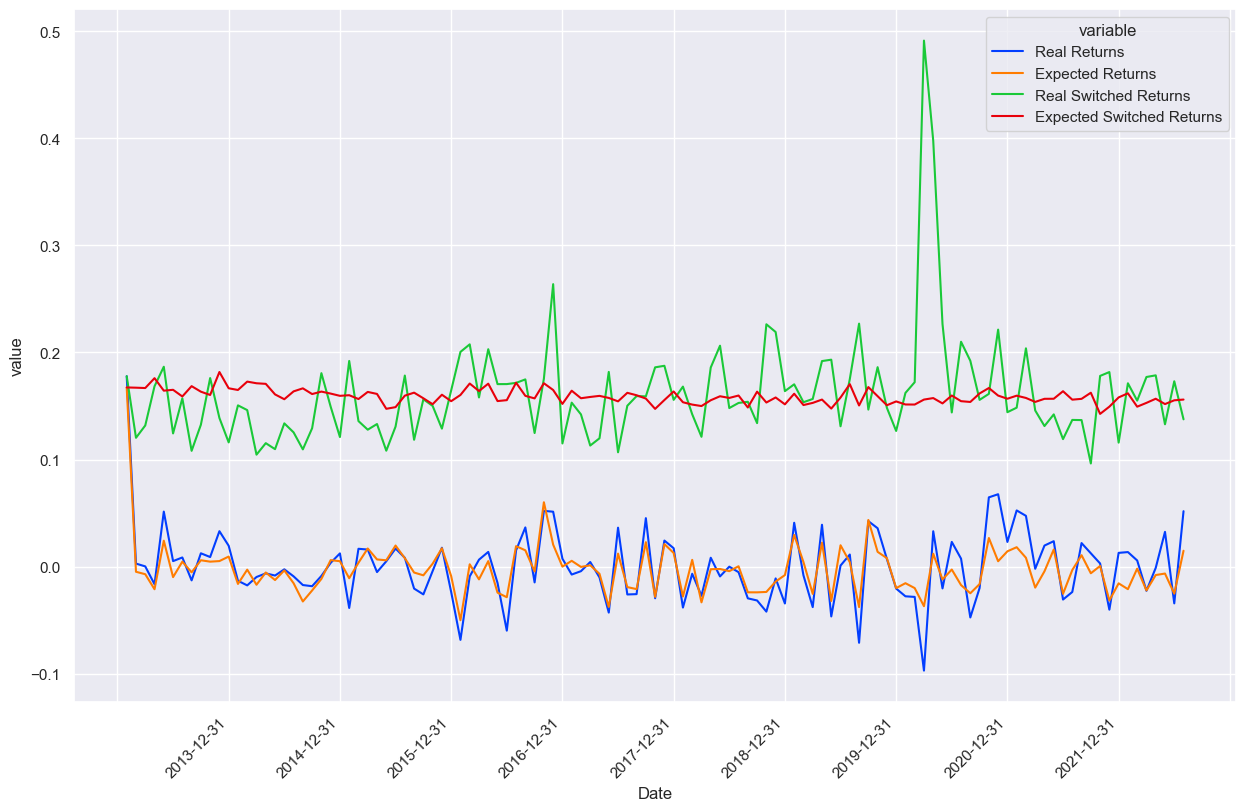

In [633]:
pca_Result = predict_returns(Enet_H_pca, "PCR")
pca_Port_spec, pca_mdd, pca_max1loss, pca_Turnover, pca_long, pca_short = analyse(pca_Result, "PCR")

In [649]:
pca_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)


,Pred,Avg,SD,SR
0.0,-0.096965,-0.023812,0.023443,-0.321296
0.1,-0.059662,0.006138,0.035499,0.149807
0.2,-0.038315,0.007318,0.039769,0.189695
0.3,-0.019253,0.008458,0.042404,0.220333
0.4,-0.005183,0.009877,0.044850,0.251334
0.5,0.006259,0.010976,0.046850,0.274002
0.6,0.021403,0.012291,0.049092,0.302017
0.7,0.044656,0.013271,0.051880,0.328200
0.8,0.058094,0.014671,0.054372,0.358239
0.9,0.076838,0.016903,0.058869,0.408495


### Portfolio obtained with the Elastic-Net Model

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

The value of the maxDD is 0.6233067389812299
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.3572286977259655
The mean value of the portfolio created with the real returns over the months is -0.0005358093465413047
The mean value of the portfolio created with the expected returns over the months is -0.0036584673829637934
The mean value of the portfolio when switching created with the real returns over the months is 0.1652660980960458
The mean value of the portfolio created switching with the expected returns over the months is 0.14766951872051043


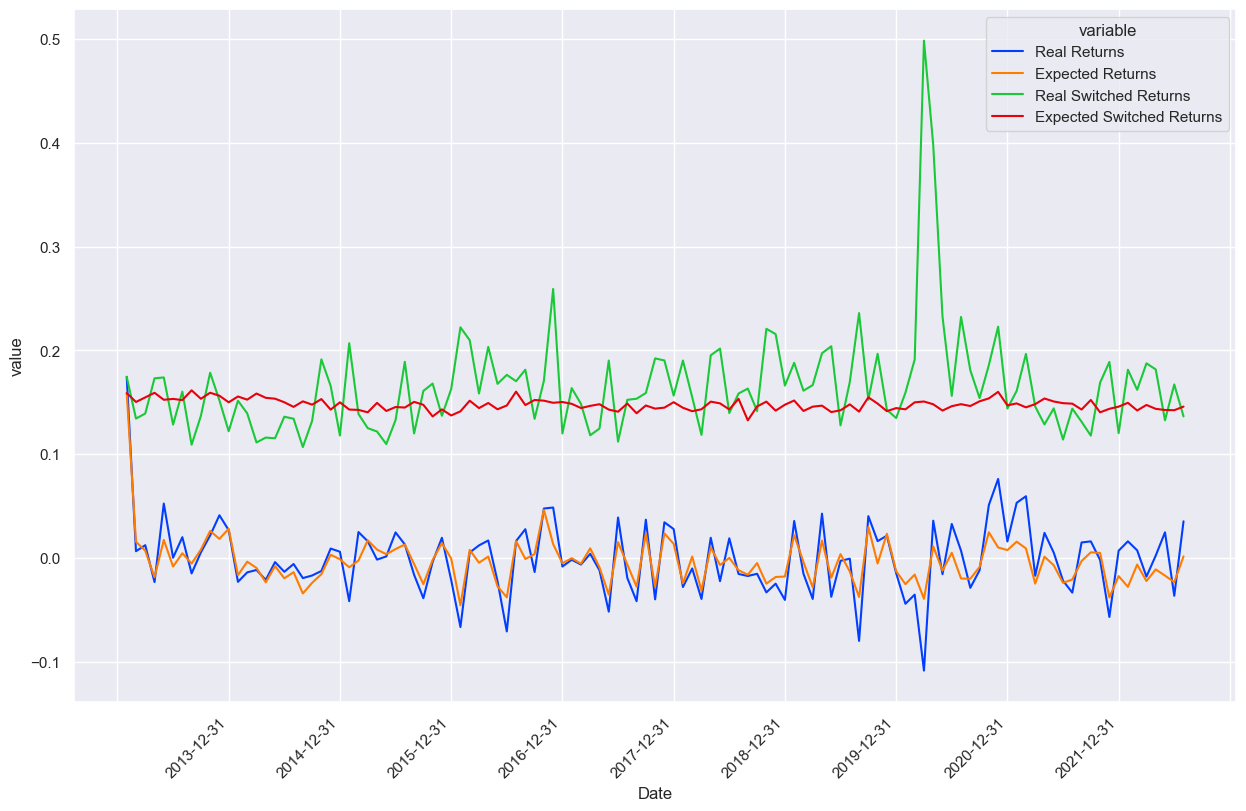

In [634]:
enet_Result = predict_returns(Enet_H, "Enet+H")
enet_Port_spec, enet_mdd, enet_max1loss, enet_Turnover, enet_long, enet_short = analyse(enet_Result, "Enet+H")

In [650]:
enet_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)

,Pred,Avg,SD,SR
0.0,-0.085153,-0.022817,0.022877,-0.403825
0.1,-0.054426,0.005184,0.033718,0.055412
0.2,-0.032809,0.007630,0.037834,0.110961
0.3,-0.018370,0.009080,0.040763,0.143472
0.4,-0.001448,0.010160,0.042817,0.165754
0.5,0.008291,0.011054,0.044226,0.193593
0.6,0.024337,0.012356,0.046303,0.222507
0.7,0.045175,0.013498,0.048921,0.252505
0.8,0.058604,0.014994,0.051351,0.285441
0.9,0.078442,0.016887,0.055179,0.335559


### Portfolio obtained with the OLS-3+H Model

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

The value of the maxDD is 0.7084797416244193
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.288386582945186
The mean value of the portfolio created with the real returns over the months is -0.0006223716639661123
The mean value of the portfolio created with the expected returns over the months is -0.0037920791124346535
The mean value of the portfolio when switching created with the real returns over the months is 0.16203231479237942
The mean value of the portfolio created switching with the expected returns over the months is 0.1466538872027522


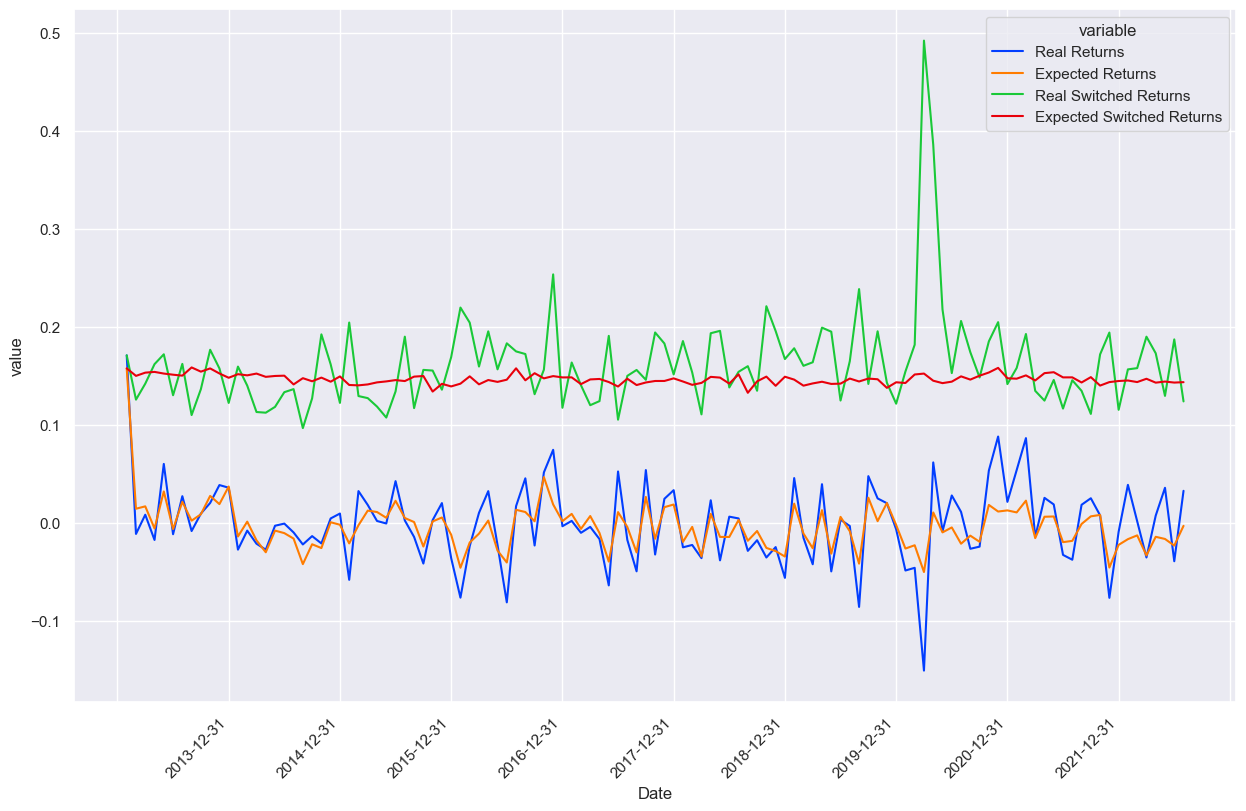

In [635]:
ols_results = predict_returns(OLS_H, "OLS-3+H")
ols_Port_spec, ols_mdd, ols_max1loss, ols_Turnover, os_long, os_short = analyse(ols_results, "OLS-3+H")

In [651]:
ols_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)

,Pred,Avg,SD,SR
0.0,-0.089361,-0.021382,0.023691,-0.438795
0.1,-0.052387,0.005840,0.033740,0.000304
0.2,-0.032704,0.008388,0.037509,0.061885
0.3,-0.017142,0.010274,0.040384,0.104165
0.4,-0.002319,0.011474,0.042353,0.129449
0.5,0.010496,0.012501,0.043790,0.158709
0.6,0.025429,0.014134,0.046000,0.190386
0.7,0.045300,0.015626,0.048515,0.228011
0.8,0.061171,0.017191,0.050673,0.266194
0.9,0.078881,0.019275,0.054827,0.324043


### Portfolio obtained with the PLS Model

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all[:, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all[:, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

The value of the maxDD is 0.5806769729215343
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.39570574172957
The mean value of the portfolio created with the real returns over the months is -0.0009818810037991305
The mean value of the portfolio created with the expected returns over the months is -0.0014417353869696913
The mean value of the portfolio when switching created with the real returns over the months is 0.16279677266992867
The mean value of the portfolio created switching with the expected returns over the months is 0.18284072049553302


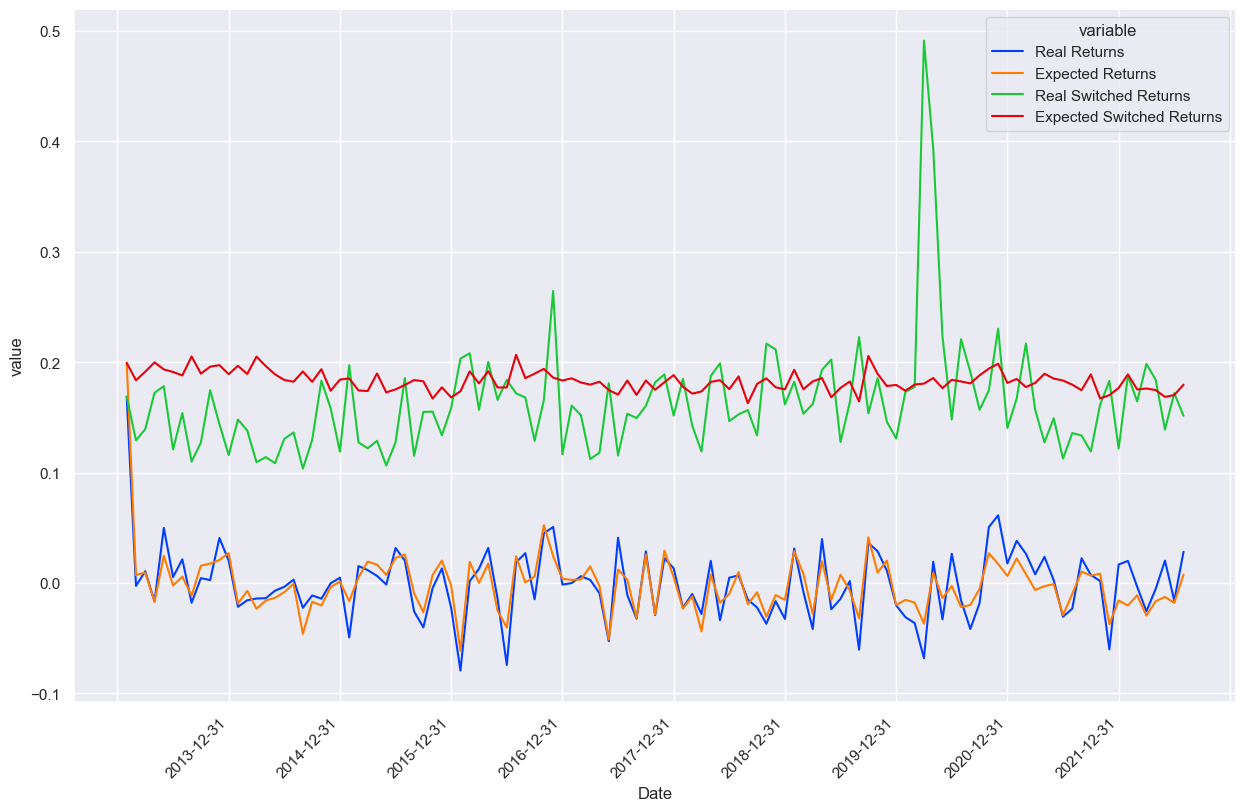

In [636]:
pls_results = predict_returns(PLS_model, "PLS")
pls_Port_spec, pls_mdd, pls_max1loss, pls_Turnover, pls_long, pls_short = analyse(pls_results, "PLS")

In [652]:
pls_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)

,Pred,Avg,SD,SR
0.0,-0.115073,-0.029608,0.028857,-0.363723
0.1,-0.074071,0.004323,0.041315,0.096084
0.2,-0.043913,0.006239,0.046318,0.129005
0.3,-0.023154,0.007552,0.049442,0.164590
0.4,-0.003602,0.009034,0.052208,0.184712
0.5,0.005218,0.010333,0.054182,0.213280
0.6,0.021917,0.011907,0.056508,0.238622
0.7,0.050271,0.013466,0.059984,0.262929
0.8,0.068857,0.015328,0.062509,0.302130
0.9,0.096862,0.018014,0.067073,0.349410


### Portfolio obtained with the NN3 Model

Epoch 1/30
2659/2659 [==============================] - 5s 1ms/step - loss: 0.0070
Epoch 2/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0059
Epoch 3/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0057
Epoch 4/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0056
Epoch 5/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0055
Epoch 6/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0054
Epoch 7/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0053
Epoch 8/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0053
Epoch 9/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0052
Epoch 10/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0052
Epoch 11/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0051
Epoch 12/30
2659/2659 [==============================] - 4s 1ms/step - loss: 0.0050
E

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

Epoch 1/30
4488/4488 [==============================] - 5s 1ms/step - loss: 0.0037
Epoch 2/30
4488/4488 [==============================] - 5s 1ms/step - loss: 0.0037
Epoch 3/30
4488/4488 [==============================] - 6s 1ms/step - loss: 0.0037
Epoch 4/30
4488/4488 [==============================] - 5s 1ms/step - loss: 0.0037
Epoch 5/30
4488/4488 [==============================] - 5s 1ms/step - loss: 0.0037
Epoch 6/30
4488/4488 [==============================] - 6s 1ms/step - loss: 0.0037
Epoch 7/30
4488/4488 [==============================] - 6s 1ms/step - loss: 0.0037
Epoch 8/30
4488/4488 [==============================] - 6s 1ms/step - loss: 0.0037
Epoch 9/30
4488/4488 [==============================] - 6s 1ms/step - loss: 0.0037
Epoch 10/30
4488/4488 [==============================] - 5s 1ms/step - loss: 0.0037
Epoch 11/30
4488/4488 [==============================] - 5s 1ms/step - loss: 0.0037
Epoch 12/30
4488/4488 [==============================] - 6s 1ms/step - loss: 0.0037
E

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

The value of the maxDD is 0.4134190927799162
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.56613269801114
The mean value of the portfolio created with the real returns over the months is 0.002037463814134496
The mean value of the portfolio created with the expected returns over the months is 0.0006137479382627846
The mean value of the portfolio when switching created with the real returns over the months is 1.570365806045091e-05
The mean value of the portfolio created switching with the expected returns over the months is 0.19773564734059287


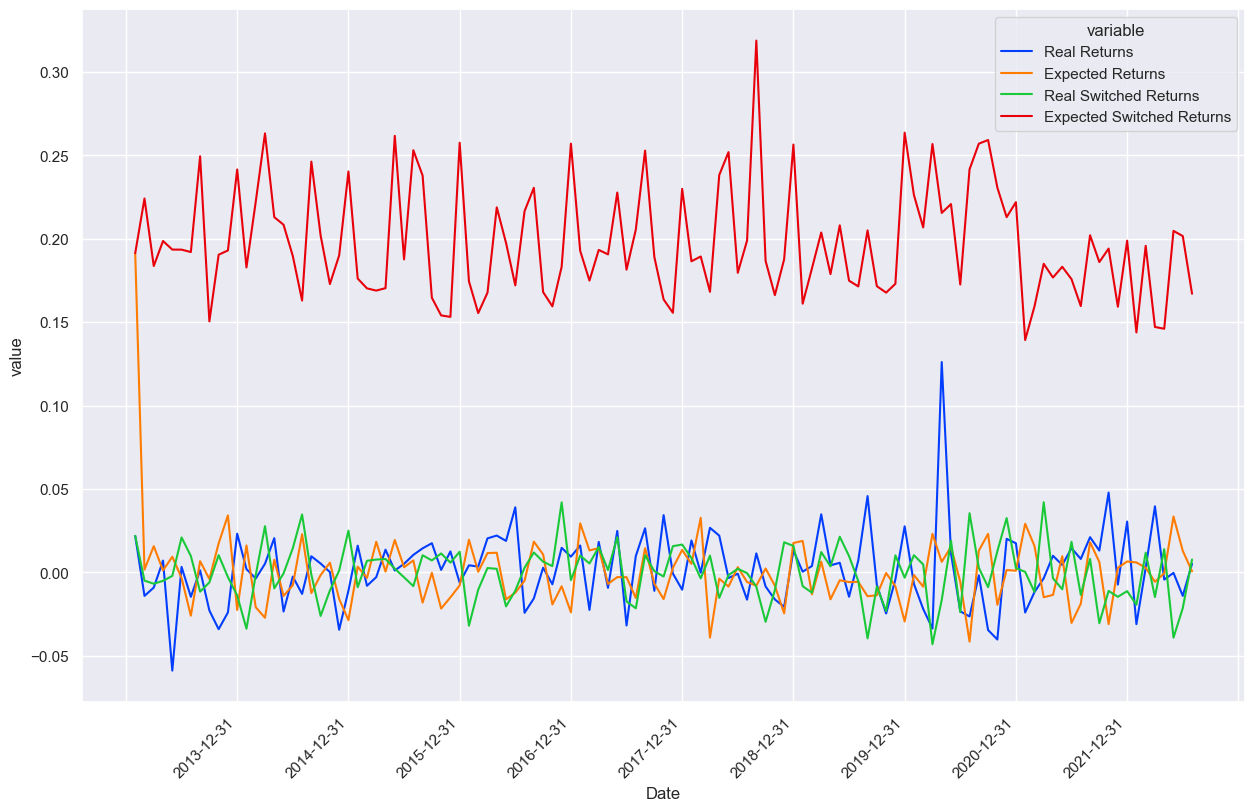

In [637]:
nn3_results = mini_predict_returns(NN3, "NN3")
nn3_Port_spec, nn3_mdd, nn3_max1loss, nn3_Turnover, nn3_long, nn3_short = analyse(nn3_results, "NN3")

In [653]:
nn3_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)

,Pred,Avg,SD,SR
0.0,-0.124044,-0.004182,0.039231,-0.175163
0.1,-0.046462,0.002000,0.045078,-0.043325
0.2,-0.027763,0.004067,0.047974,-0.009079
0.3,-0.014739,0.005536,0.050043,0.015247
0.4,-0.006022,0.006889,0.052945,0.044687
0.5,0.003300,0.008119,0.055189,0.067998
0.6,0.011480,0.009662,0.057636,0.095328
0.7,0.019439,0.011406,0.060682,0.134823
0.8,0.037808,0.013797,0.064771,0.156209
0.9,0.061028,0.015564,0.072064,0.188258


### Portfolio obtained with the NN4 Model

Epoch 1/30
2659/2659 [==============================] - 6s 2ms/step - loss: 0.0070
Epoch 2/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0060
Epoch 3/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0058
Epoch 4/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0057
Epoch 5/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0056
Epoch 6/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0055
Epoch 7/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0054
Epoch 8/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0054
Epoch 9/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0053
Epoch 10/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0053
Epoch 11/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0052
Epoch 12/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0052
E

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

Epoch 1/30
  18/4488 [..............................] - ETA: 13s - loss: 0.0031

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]


4488/4488 [==============================] - 8s 2ms/step - loss: 0.0038
Epoch 2/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0038
Epoch 3/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 4/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 5/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 6/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0038
Epoch 7/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 8/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 9/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 10/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 11/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 12/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 13/30


/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

The value of the maxDD is 0.28091618107563965
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.5845278574618873
The mean value of the portfolio created with the real returns over the months is 0.0004865120507678567
The mean value of the portfolio created with the expected returns over the months is 0.0010919942504984874
The mean value of the portfolio when switching created with the real returns over the months is 0.00148985847004767
The mean value of the portfolio created switching with the expected returns over the months is 0.21079759828236325


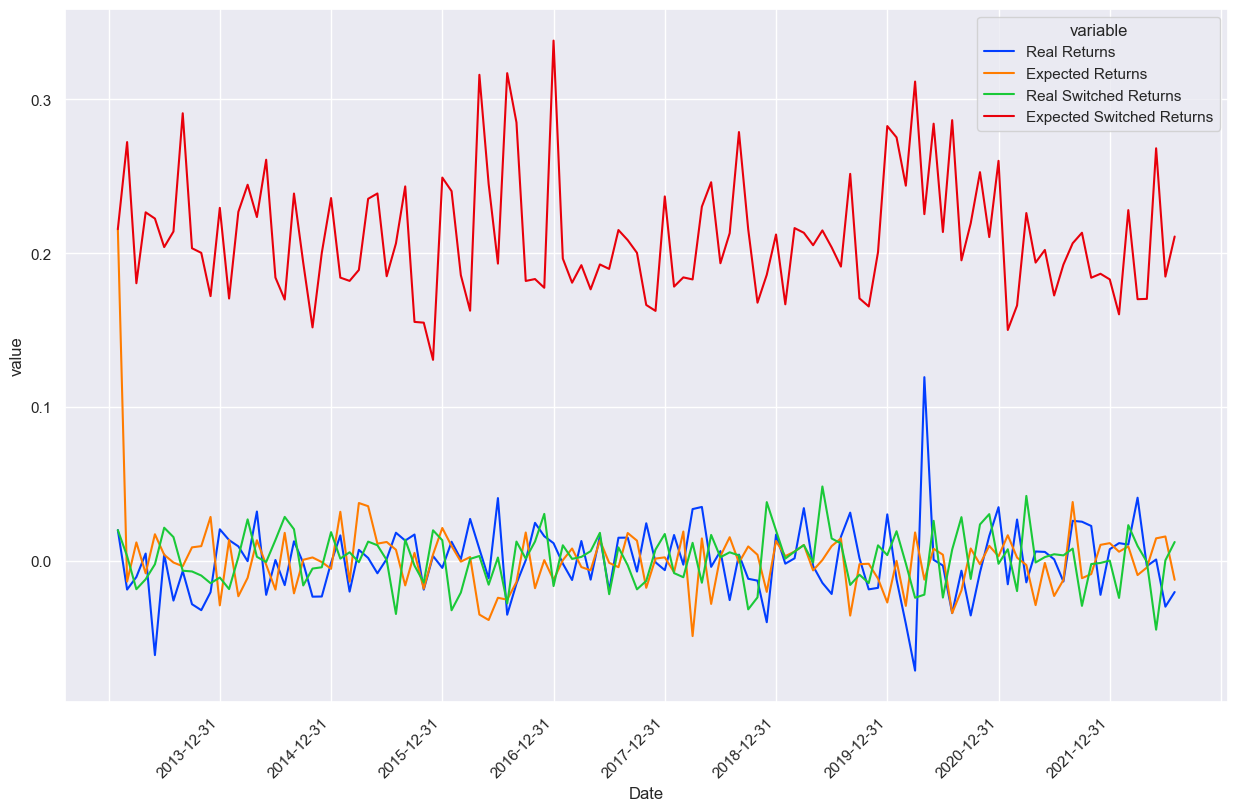

In [638]:
nn4_results = mini_predict_returns(NN4, "NN4")
nn4_Port_spec, nn4_mdd, nn4_max1loss, nn4_Turnover, nn4_long, nn4_short = analyse(nn4_results, "NN4")

In [654]:
nn4_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)

,Pred,Avg,SD,SR
0.0,-0.151655,-0.007939,0.036653,-0.125834
0.1,-0.044901,0.002399,0.046489,0.052033
0.2,-0.025564,0.005234,0.049162,0.097474
0.3,-0.012193,0.006799,0.052742,0.128021
0.4,0.001438,0.008079,0.054943,0.145273
0.5,0.010037,0.009759,0.059252,0.174605
0.6,0.016290,0.010995,0.062210,0.195495
0.7,0.024938,0.012562,0.066233,0.224284
0.8,0.036202,0.014483,0.070637,0.255404
0.9,0.075532,0.017028,0.078745,0.288219


### Portfolio obtained with the NN5 Model

Epoch 1/30
2659/2659 [==============================] - 6s 2ms/step - loss: 0.0069
Epoch 2/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0059
Epoch 3/30
2659/2659 [==============================] - 5s 2ms/step - loss: 0.0058
Epoch 4/30
2659/2659 [==============================] - 5s 2ms/step - loss: 0.0057
Epoch 5/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0056
Epoch 6/30
2659/2659 [==============================] - 5s 2ms/step - loss: 0.0055
Epoch 7/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0054
Epoch 8/30
2659/2659 [==============================] - 5s 2ms/step - loss: 0.0054
Epoch 9/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0053
Epoch 10/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0053
Epoch 11/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0052
Epoch 12/30
2659/2659 [==============================] - 4s 2ms/step - loss: 0.0052
E

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

Epoch 1/30
  11/4488 [..............................] - ETA: 22s - loss: 0.0034

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]


4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 2/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 3/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 4/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 5/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 6/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 7/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 8/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 9/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 10/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 11/30
4488/4488 [==============================] - 7s 2ms/step - loss: 0.0037
Epoch 12/30
4488/4488 [==============================] - 8s 2ms/step - loss: 0.0037
Epoch 13/30


/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j, 0]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

The value of the maxDD is 0.35077616335584794
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.5526506910587017
The mean value of the portfolio created with the real returns over the months is 0.0016512992706703721
The mean value of the portfolio created with the expected returns over the months is 3.786152820523362e-05
The mean value of the portfolio when switching created with the real returns over the months is 0.0017562502000540259
The mean value of the portfolio created switching with the expected returns over the months is 0.20373035513155158


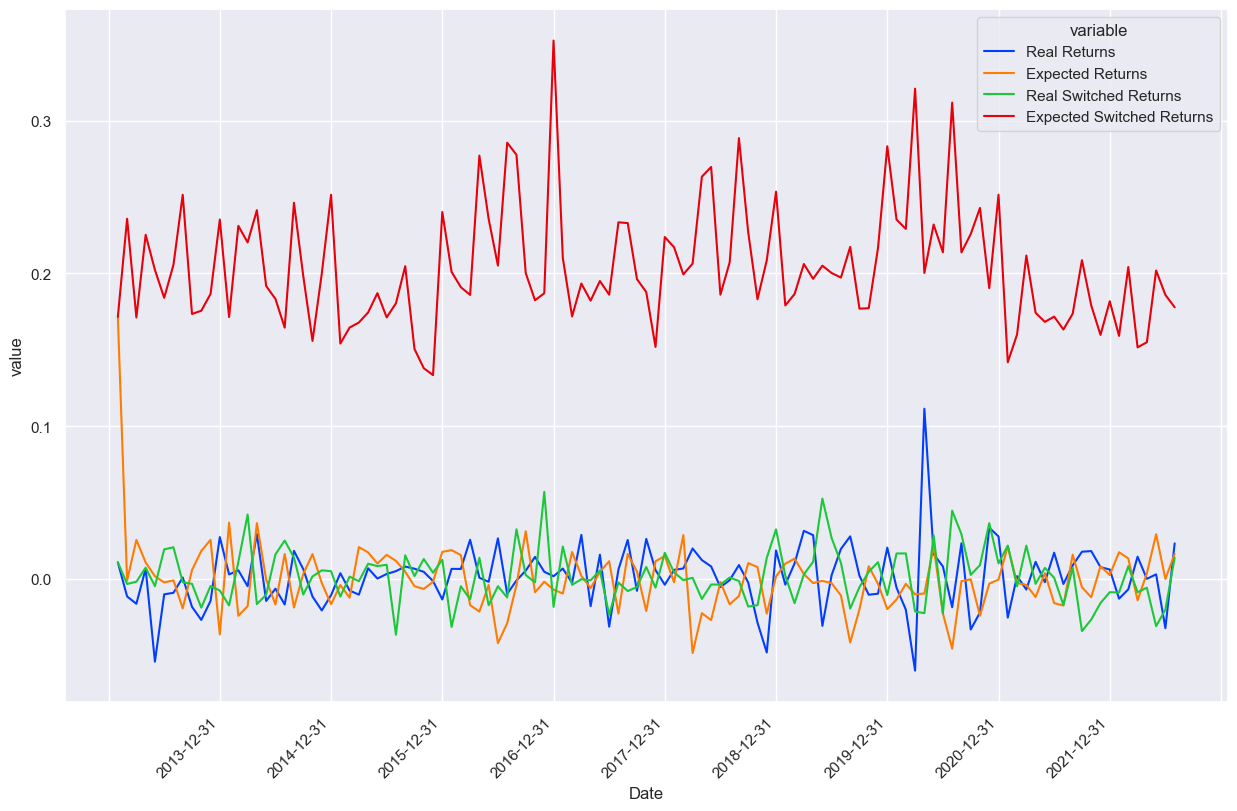

In [639]:
nn5_results = mini_predict_returns(NN5, "NN5")
nn5_Port_spec, nn5_mdd, nn5_max1loss, nn5_Turnover, nn5_long, nn5_short = analyse(nn5_results, "NN5")

In [655]:
nn5_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)

,Pred,Avg,SD,SR
0.0,-0.269579,-0.007120,0.034895,-0.152669
0.1,-0.038625,0.003877,0.047358,0.022475
0.2,-0.022304,0.005866,0.050056,0.054217
0.3,-0.011959,0.007699,0.052342,0.085725
0.4,0.000351,0.008943,0.055147,0.113863
0.5,0.006876,0.010300,0.057787,0.131005
0.6,0.016174,0.011751,0.059324,0.157983
0.7,0.028290,0.013549,0.062523,0.183424
0.8,0.044268,0.015233,0.067304,0.211726
0.9,0.074108,0.017817,0.073690,0.253191


### Portfolio obtained with the Random Forest Model

<class 'numpy.ndarray'>
[ 0.02206299  0.00313057  0.00685472 ...  0.14193575  0.04710892
 -0.05221702]
<class 'numpy.ndarray'>
[-2.32545446e-05  4.35803679e-02  7.71831329e-03 ... -1.02310512e-01
  1.77348174e-01  2.06152975e-02]
<class 'numpy.ndarray'>
[ 0.02424899 -0.00884853  0.00904586 ... -0.09899152  0.02304934
 -0.05483744]
<class 'numpy.ndarray'>
[6.40357486e-02 5.10167747e-02 6.45889339e-05 ... 1.00513308e-01
 8.56404479e-02 1.72415688e-02]
<class 'numpy.ndarray'>
[ 0.01768951  0.03476026  0.02567111 ... -0.07643747 -0.07074132
 -0.05234416]
<class 'numpy.ndarray'>
[ 0.0340256   0.00556232 -0.0225275  ... -0.06308315 -0.04065332
  0.119665  ]
<class 'numpy.ndarray'>
[-0.0575466  -0.02522933 -0.00857478 ... -0.06372455 -0.05109217
  0.01483611]
<class 'numpy.ndarray'>
[-0.07245469  0.07456736  0.06071426 ...  0.08298451 -0.07193976
  0.06495219]
<class 'numpy.ndarray'>
[ 0.05938304 -0.00774055  0.05037521 ... -0.05068919  0.05396095
 -0.04401556]


/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

<class 'numpy.ndarray'>
[-0.01495128 -0.0250644   0.02191344 ...  0.00222954  0.05532801
 -0.05454948]


/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+j]] = month_predict_all[nbr*(j-1): nbr*j]
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/608741906.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of

The value of the maxDD is 0.20720515907365317
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.565968759953256
The mean value of the portfolio created with the real returns over the months is -0.0004887470832998743
The mean value of the portfolio created with the expected returns over the months is 9.5479571395097e-05
The mean value of the portfolio when switching created with the real returns over the months is 0.0022122616594786103
The mean value of the portfolio created switching with the expected returns over the months is 0.1585295905963872


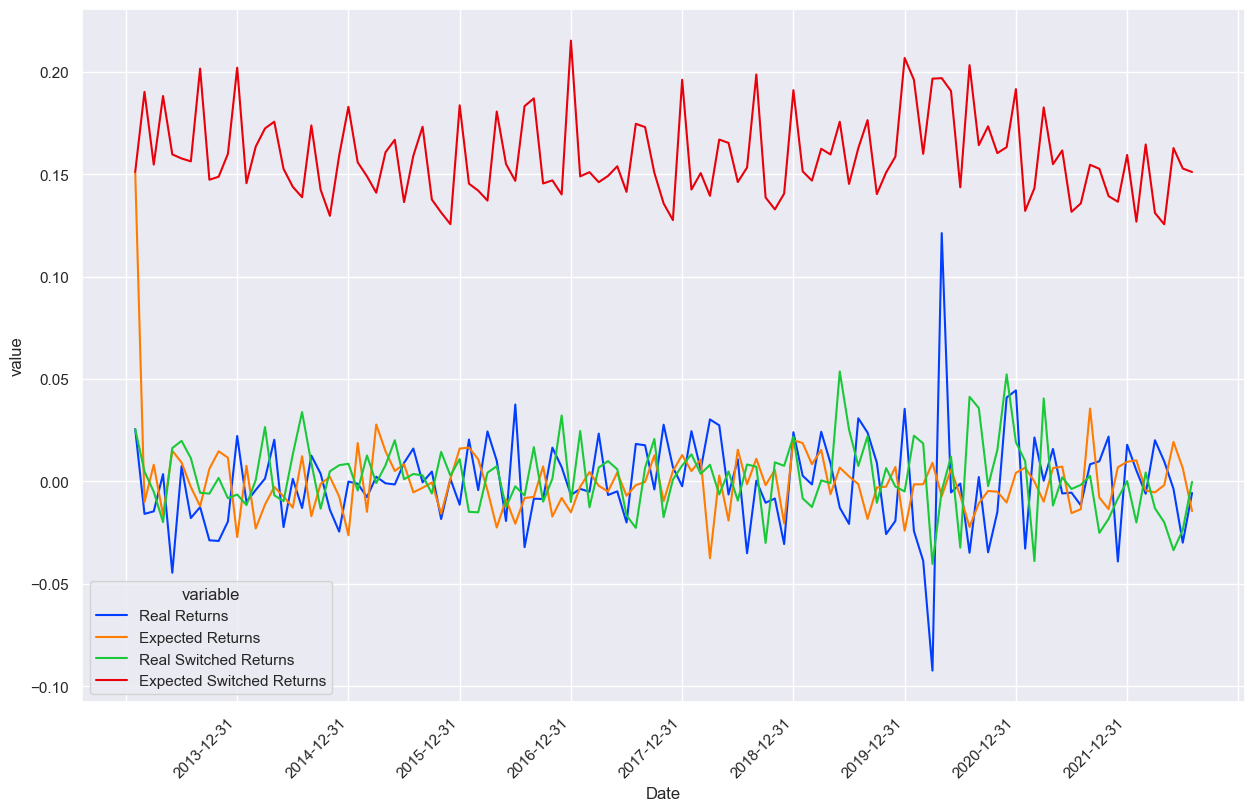

In [640]:
rf_results = mini_predict_returns(RF, "RF")
rf_Port_spec, rf_mdd, rf_max1loss, rf_Turnover, rf_long, rf_short = analyse(rf_results, "RF")

In [656]:
rf_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)

,Pred,Avg,SD,SR
0.0,-0.096691,0.001378,0.031357,0.131845
0.1,-0.035455,0.007120,0.038064,0.249324
0.2,-0.023695,0.008656,0.039983,0.286391
0.3,-0.009171,0.009540,0.041765,0.315789
0.4,0.001546,0.010651,0.043023,0.337732
0.5,0.008765,0.011513,0.044096,0.364561
0.6,0.016345,0.013034,0.046241,0.391184
0.7,0.025067,0.014254,0.047259,0.415431
0.8,0.038522,0.015930,0.050429,0.447625
0.9,0.065188,0.017294,0.053121,0.488452


### Portfolio obtained with the Gradient Boosting Regression Model

/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Result[dates[k+1]] = month_predict_all
/var/folders/qd/0_ssndb54pl41p5q5ht96th40000gn/T/ipykernel_12701/1919541134.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

The value of the maxDD is 0.410850395921466
The value of the Max1Mloss is -0.832263274214967
The value of the turnover is 3.336462454396333
The mean value of the portfolio created with the real returns over the months is 0.001517911042464362
The mean value of the portfolio created with the expected returns over the months is 0.00216168981715441
The mean value of the portfolio when switching created with the real returns over the months is 0.16304703982835478
The mean value of the portfolio created switching with the expected returns over the months is 0.14736769490448665


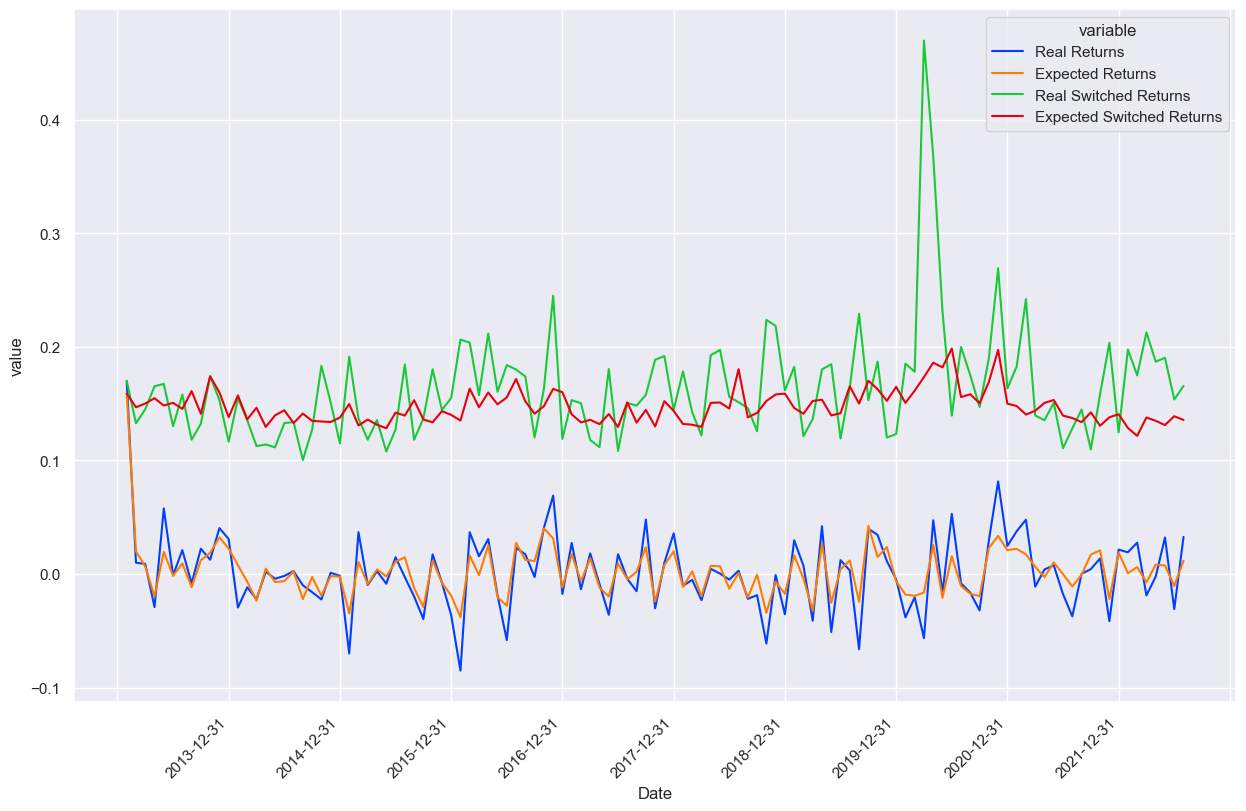

In [641]:
gbr_results = predict_returns(GBR, "GBR")
gbr_Port_spec, gbr_mdd, gbr_max1loss, gbr_Turnover, gbr_long, gbr_short = analyse(gbr_results, "GBR")

In [657]:
gbr_Port_spec.quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], axis = 0)

,Pred,Avg,SD,SR
0.0,-0.098813,0.000388,0.015718,-0.022757
0.1,-0.024649,0.008351,0.024301,0.122466
0.2,-0.014560,0.010211,0.026460,0.194497
0.3,-0.002082,0.011178,0.030275,0.222456
0.4,0.005994,0.011928,0.032350,0.263506
0.5,0.013565,0.012469,0.035485,0.293805
0.6,0.020490,0.013561,0.038509,0.325017
0.7,0.030525,0.014642,0.044172,0.363926
0.8,0.044119,0.015962,0.049202,0.396164
0.9,0.069332,0.017131,0.059871,0.472371


### Comparing the returns of the portfolio with different Machine Learning methods

##### First the "fixed portfolio"

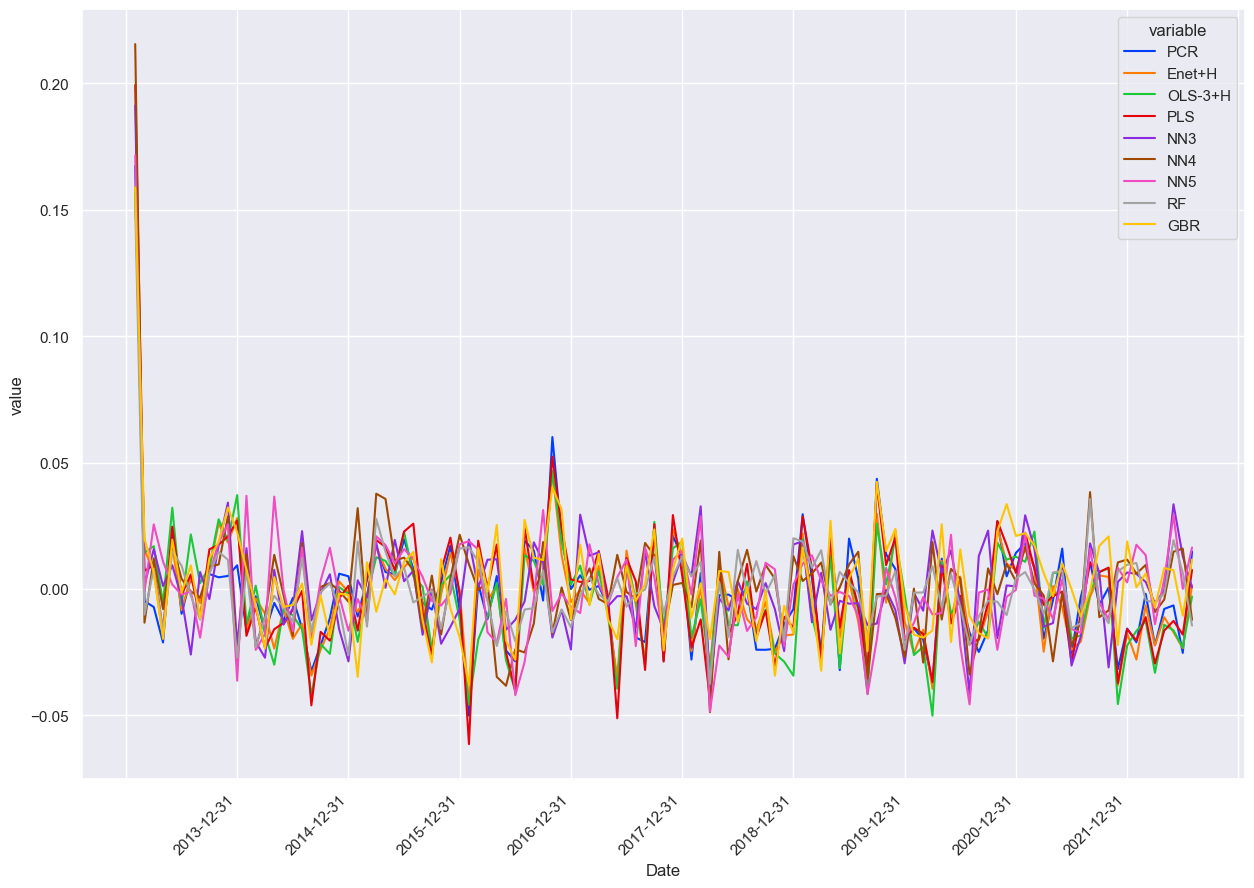

In [642]:
Cpr_methods = pd.DataFrame(compare_methods)
Cpr_methods["Date"] = enet_Result.columns
plt.figure(figsize=(15,10))

sns.set_theme(style="darkgrid")

chart = sns.lineplot(x='Date', y='value', hue='variable', 
            data=pd.melt(Cpr_methods, ['Date']),
            palette="bright")

plt.xticks(rotation=45,horizontalalignment='right',fontweight='light')
locator = mdates.DayLocator(interval=12)
chart.xaxis.set_major_locator(locator)
plt.savefig("Img/compar_port_returns.pdf")
plt.show()

##### Now the "switching" portfolio

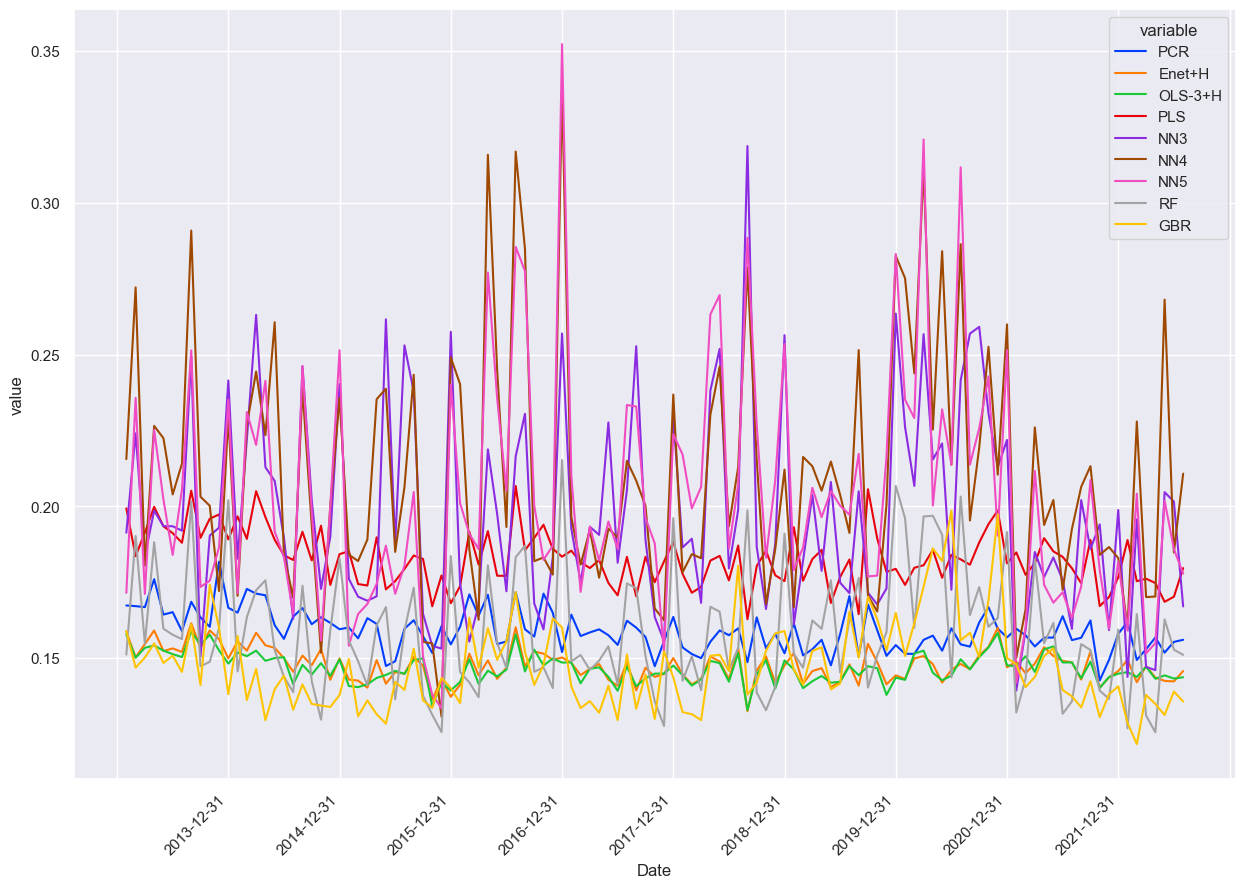

In [643]:
Cpr_methods_switch = pd.DataFrame(compare_methods_switch)
Cpr_methods_switch["Date"] = enet_Result.columns
plt.figure(figsize=(15,10))

sns.set_theme(style="darkgrid")

chart = sns.lineplot(x='Date', y='value', hue='variable', 
            data=pd.melt(Cpr_methods_switch, ['Date']),
            palette="bright")

plt.xticks(rotation=45,horizontalalignment='right',fontweight='light')
locator = mdates.DayLocator(interval=12)
chart.xaxis.set_major_locator(locator)
plt.savefig("Img/compar_port_switch_returns.pdf")
plt.show()

### The cumulated returns of the portfolio with different methods

In [644]:
Cumulate

,Date,Value,Type,Method
0,2013-01-31,0.095533,Long,PCR
1,2013-02-28,0.104071,Long,PCR
2,2013-03-31,0.120331,Long,PCR
3,2013-04-30,0.109211,Long,PCR
4,2013-05-31,0.143735,Long,PCR
...,...,...,...,...
2065,2022-03-31,-1.514482,Short,GBR
2066,2022-04-30,-1.529450,Short,GBR
2067,2022-05-31,-1.536120,Short,GBR
2068,2022-06-30,-1.536123,Short,GBR


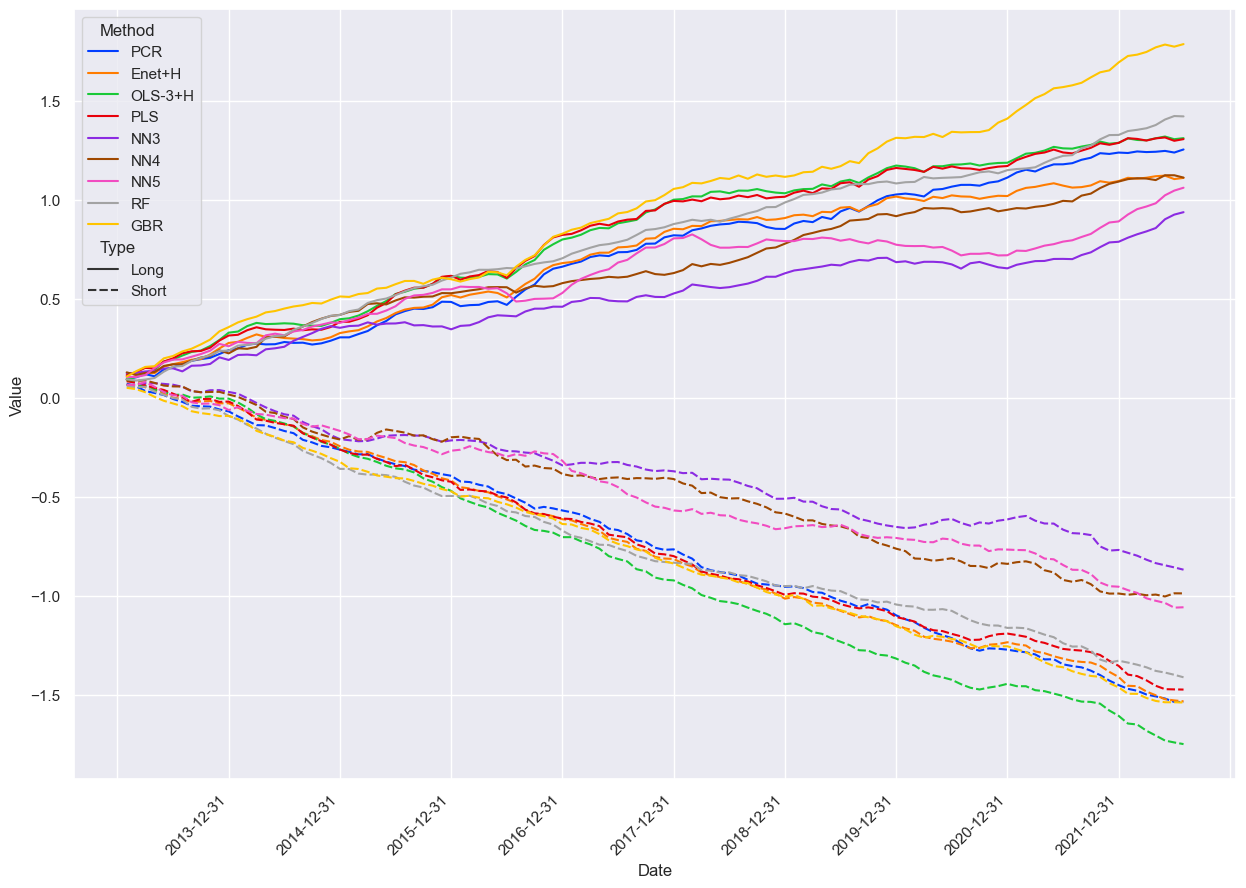

In [645]:
plt.figure(figsize=(15,10))
chart = sns.lineplot(data=Cumulate, x="Date", y="Value", hue="Method", style="Type",palette="bright")
plt.xticks(rotation=45,horizontalalignment='right',fontweight='light')
locator = mdates.DayLocator(interval=12)
chart.xaxis.set_major_locator(locator)
plt.savefig("Img/Cumulated_returns.pdf")
plt.show()
